# Landmark Classifier

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo’s location can often be obtained by looking at the photo’s metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo’s metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

This notebook classifies 50 landmarks by building models to automatically predict the location of the image based on any landmarks depicted in the image.

### Table of Content

In [51]:
# import all the packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torchsummary import summary

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision.models as models
from torchvision import transforms as T

from utils import create, preprocess

In [2]:
# define the batch size
BATCH_SIZE = 8

# get the loaders
train_loader, val_loader, test_loader, dataset = preprocess.create_loaders(n_batch=BATCH_SIZE)

In [3]:
# store loaders
loaders = {'train': train_loader,
           'val':   val_loader,
           'test':  test_loader}

# get dictionary and descriptions
dictionary = preprocess.Dictionary(dataset)

# show first three instances
dictionary.simple_print(3)

						Classes & Indexes
0:	Haleakala National Park
1:	Mount Rainier National Park
2:	Ljubljana Castle


IndexError: index 8 is out of bounds for dimension 0 with size 8

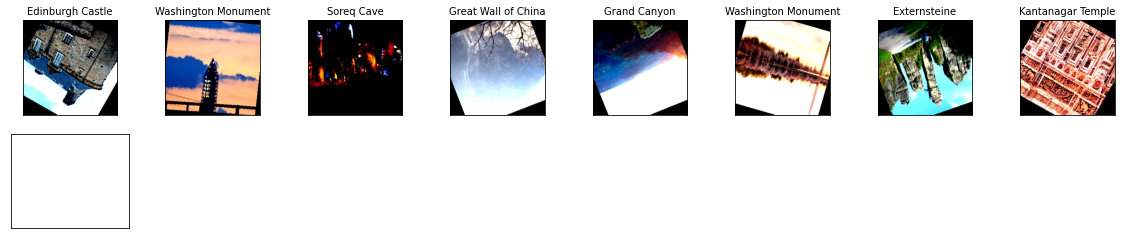

In [4]:
preprocess.visualize(dictionary, train_loader, single=False)

In [5]:
# initialize cuda
cuda = torch.cuda.is_available()
cuda

True

In [6]:
model = models.vgg16(pretrained=True)

if cuda:
    model = model.cuda()

In [7]:
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 50)
print(model.classifier)

if cuda:
    model.cuda()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=50, bias=True)
)


In [8]:
## select loss function
criterion = nn.CrossEntropyLoss()
optimizer, lr_decay = create.get_optimizer(model)

# model = create.train(20, loaders, model, optimizer, criterion,
#                      cuda, 'model_vgg16.pt', lr_decay)

In [9]:
model.load_state_dict(torch.load('checkpoints/model_vgg16.pt'))

create.test(loaders, model, criterion, cuda)

Test Loss: 1.308560


Test Accuracy: 68% (851/1250)


In [45]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(k:int, cuda=True):
    """
    This function read the image file, applies appropriate transformations, predicts top K locations of images.

    Parameters:
         img_path (str): Path to an image
         k (int): Top locations to show

    Returns:
        transformed image and pretty formatted location predictions
    """

    temp = preprocess.get_random_image('data/train')

    transform = T.Compose([
            T.Resize((226, 226)),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
                mean=preprocess.MEAN,
                std=preprocess.STD
            )
    ])

    img = temp.copy()
    img = transform(img).unsqueeze_(0)
    img = img.cuda() if cuda else img

    # pass the model in evaluation mode
    model.eval()

    # get predictions
    output = model(img)

    # apply softmax to get probabilities
    output = F.softmax(output, dim=1)

    # show top K location predictions
    topk = torch.topk(output, k)
    prob = topk[0][0].detach().cpu().numpy()

    return temp, dictionary.get_content(topk[1].detach().cpu().numpy()[0]), prob

# test on a sample image
img, output, probs = predict_landmarks(5)
output

'Seattle Japanese Garden, Central Park, Externsteine, Great Wall of China, Machu Picchu'

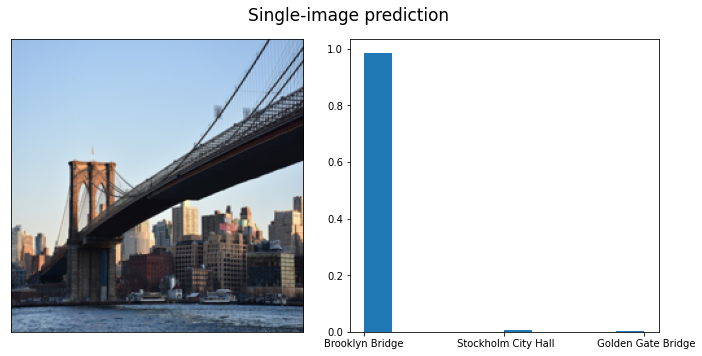

In [99]:
def suggest_locations():
    """
    This function shows the final image and associated K predictions.

    """
    # get landmark predictions
    img, predicted_landmarks, probs = predict_landmarks(k=3)

    preds = pd.DataFrame({'loc': predicted_landmarks.split(','),
                          'prob': probs})
    preds['prob'] = preds['prob'].apply(lambda x: float(format(x, '.3f')))
    preds = preds.sort_values('prob', ascending=False)

    # normalize the image and show the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img.resize((226, 226)))
    ax[0].grid(False); ax[0].set_xticks([]); ax[0].set_yticks([])

    # show probabilities
    ax[1].hist(preds['loc'], weights=preds['prob'])

    # add title and show
    fig.suptitle('Single-image prediction', fontsize=17)
    plt.tight_layout()
    plt.show()

# test on a sample image
suggest_locations()

In [25]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()
torch.cuda.empty_cache()

| ID | GPU | MEM |
------------------
|  0 |  0% | 89% |


In [26]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x000001704AE010E0 to Device at 0x000001704ABA49A0>